# Using Convolutional Neural Networks (CNNs) to Classify Digits

## CNN Background

Convolutional neural networks (CNNs) are kinds of neural networks that are useful in computer vision.

There are four main operations in a CNN (adapted from <i><a href="https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/">An Intuitive Explanation of Convolutional Neural Networks</a></i>):

- Convolution
    - Convolution preserves spatial data between pixels and learns image features by "convolving" filters across an image. We slide the filter over the original image by our stride and compute an element wise multiplication. We add the output to the corresponding index of the feature map. In this sense, filters act as "feature detectors" in images.
    - Different filters can produce different feature maps and help in operations such as edge detection, blur, and sharpening.
    - In practice, the CNN learns the values of filters during the training process. However, a human still much specify parameters such as the # of filters, filter size, etc. Generally, the more filters we have, the more image features we can extract and the better the system becomes when classifying unseen images.
    - The size of a feature map is controlled by depth (# of filters; this creates a "volume"), stride (# of pixels we slide the filter matrix over the input matrix), and zero-padding (padding the input matrix with zeroes on the border so we can apply the filter to bordering elements).
    
- Non-linearity
    - After every convolution operation, a non-linear operation (such as ReLU) is applied. This introduces non-linearity and helps our model become more complex.
    
- Pooling
    - Pooling, or downsampling, reduces the dimensionality of the feature map but retains important information. Max pooling takes the largest element from the feature map within that window. After pooling, we are left with a reduced spatial size of the input representation.
    
- Classification 
    - A fully-connected layer acts as a classifier. The output from the previous convolution and pooling layers represent high-level features of the input image. We use a fully-connecting layer (every neuron in the previous layer is connected to every neuron on the left layer) to use these features for classifying the input image into various classes based on the training dataset. Then backpropogation is used to minimize the output error.

To summarize:

1) We initialize all filters and parameters / weights with random values
2) The network takes a training image as input, goes through the forward propagation step (convolution, ReLU and pooling operations along with forward propagation in the Fully Connected layer) and finds the output probabilities for each class. Since weights are randomly assigned for the first training example, output probabilities are also random.
3) Calculate the total error at the output layer
4) Use Backpropagation to calculate the gradients of the error with respect to all weights in the network and use gradient descent to update all filter values / weights and parameter values to minimize the output error. The weights are adjusted in proportion to their contribution to the total error. Parameters like number of filters, filter sizes, architecture of the network etc. have all been fixed before Step 1 and do not change during training process – only the values of the filter matrix and connection weights get updated.
5) Repeat steps 2-4 with all images in the training set.

<hr>

## Classifying Digits with CNNs

I will be using the famous <a href="https://www.kaggle.com/c/digit-recognizer">MNIST dataset</a> to develop a CNN to classifying digits. According to its Kaggle page:

<i> MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike. </i>

I'll begin by loading in the data and then focusing on preprocessing (normalization, reshape, and label encoding. Then, I will split the data into training and testing sets. Then I will implelent the model with Keras, and then evaluate the model using a confusion matrix.

### Loading in Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
import os
print(os.listdir("./data"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [3]:
# load in training data

train = pd.read_csv("./data/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# load in test data

test = pd.read_csv("./data/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# using label column to create Y_train

Y_train = train["label"]

# create X_train and drop label column

X_train = train.drop(labels=["label"],axis=1)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

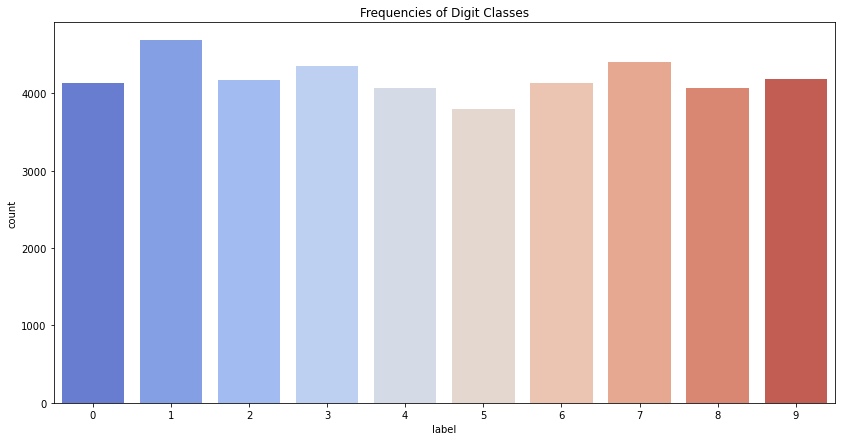

In [7]:
# visualize digit class frequencies

plt.figure(figsize=(14,7))
counts = sns.countplot(x=Y_train, palette="coolwarm")
plt.title("Frequencies of Digit Classes")
Y_train.value_counts()

Now that I've created training/testing sets and visualized the frequencies of digit classes, I'll plot some images to see what they look like.

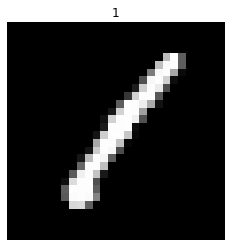

In [8]:
sample_img1 = X_train.iloc[0].to_numpy()
sample_img1 = sample_img1.reshape((28,28))
plt.imshow(sample_img1,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

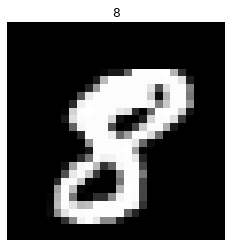

In [9]:
sample_img2 = X_train.iloc[10].to_numpy()
sample_img2 = sample_img2.reshape((28,28))
plt.imshow(sample_img2,cmap='gray')
plt.title(train.iloc[10,0])
plt.axis("off")
plt.show()

### Checking for Null Values

In [10]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

No missing values in either.

### Normalizing, Reshaping, and Label Encoding

All operations are critical to being able to feed in appropriate data to the CNN.

- Normalization: We'll do a grayscale normalization to change the range of pixel intensity values.
- Reshape: We'll reshape our data to 28 x 28 x 1 3D matrices. The 1 is the channel – grayscaled images use one channel, while color images use 3 (RGB)
- Label Encoding: We'll encode labels to one hot vectors

In [12]:
# normalization

X_train = X_train / 255.0
test = test / 255.0
print("X_train shape: ",X_train.shape)
print("test shape: ",test.shape)

X_train shape:  (42000, 784)
test shape:  (28000, 784)


In [13]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

X_train = X_train.values.reshape(-1,28,28,1) 
test = test.values.reshape(-1,28,28,1)
print("X_train shape: ",X_train.shape)
print("test shape: ",test.shape)

X_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


Now the train and test images have been stored into a pandas DataFrame as 1D vectors of 784 values – we reshaped the data to 28 x 28 x 1 3D matrices.

In [14]:
# Encode labels to one hot vectors 

Y_train = to_categorical(Y_train, num_classes = 10)

### Splitting the Training Set Further

We split the training set further into another training and test set.

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

### Building the Neural Network

<img src="https://preview.ibb.co/nRkBpp/gec2.jpg"/>

We'll use Keras to build our CNN. We'll also use dropout, a regularization technique where randomly selected neurons are ignored during training. We'll choose `adam` for our optimizer, and then compile the model using categorical cross entropy.

In [16]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.20))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [17]:
# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

### Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

Now, we can move to fit the model.

In [22]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=200),
                              epochs = 10, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 200)

/Users/natasharavinand/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
189/189 - 64s - loss: 0.5683 - accuracy: 0.8139 - val_loss: 0.0646 - val_accuracy: 0.9807
Epoch 2/10
189/189 - 64s - loss: 0.1607 - accuracy: 0.9516 - val_loss: 0.0394 - val_accuracy: 0.9883
Epoch 3/10
189/189 - 63s - loss: 0.1161 - accuracy: 0.9657 - val_loss: 0.0382 - val_accuracy: 0.9893
Epoch 4/10
189/189 - 62s - loss: 0.1006 - accuracy: 0.9701 - val_loss: 0.0333 - val_accuracy: 0.9883
Epoch 5/10
189/189 - 62s - loss: 0.0850 - accuracy: 0.9737 - val_loss: 0.0259 - val_accuracy: 0.9912
Epoch 6/10
189/189 - 63s - loss: 0.0726 - accuracy: 0.9779 - val_loss: 0.0251 - val_accuracy: 0.9917
Epoch 7/10
189/189 - 64s - loss: 0.0686 - accuracy: 0.9799 - val_loss: 0.0244 - val_accuracy: 0.9936
Epoch 8/10
189/189 - 66s - loss: 0.0585 - accuracy: 0.9827 - val_loss: 0.0178 - val_accuracy: 0.9938
Epoch 9/10
189/189 - 63s - loss: 0.0593 - accuracy: 0.9820 - val_loss: 0.0221 - val_accuracy: 0.9924
Epoch 10/10
189/189 - 65s - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.0181 - val_accura

### Evaluating the Model

We can analyze our model by calculating `Y_pred` and creating a confusion matrix.

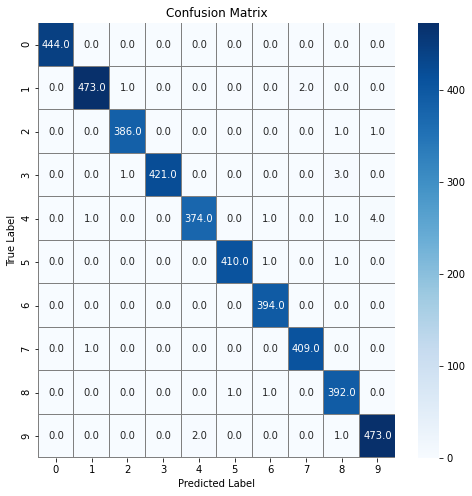

In [23]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()